# Veritas Fairness Assement - Life Insurance Underwriting Study (sample code)
This notebook includes samples of code used in the analysis conducted during the life insurance underwriting case study.

It is applicable to insurance underwriting datasets including a life insurance dataset available on
[kaggle](https://www.kaggle.com/c/prudential-life-insurance-assessment/data)

## License

Written by Sankarshan Mridha (Swiss Re) and Laura Alvarez (Accenture) as an extension to Phase 1 Credit Scoring Use Case code https://github.com/veritas-project/phase1/tree/main/credit_scoring 

Contact email: Veritas@mas.gov.sg


Copyright © 2021 Monetary Authority of Singapore

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the Licens

## Imports

In [1]:
# Core Packages
import os
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, brier_score_loss, precision_score,\
recall_score, balanced_accuracy_score
import joblib
import seaborn as sns

SEED = 123

### 1.  Import RAI library

In [2]:
from responsibleML import responsible_model as rai_model
from responsibleML import rai_models
from responsibleML import ProblemType
from responsibleML import ModelFramework

In [8]:
!pip install imblearn

In [5]:
# Our code (autoreload)
%load_ext autoreload
%autoreload 2
sys.path.append("../utils")
#import utility as utils

In [6]:
# High-res plots
%config InlineBackend.figure_format = 'retina'

In [7]:
import warnings
warnings.filterwarnings('ignore') 

### 2. Create RAI Model List

In [3]:
#Create a Model List
models = rai_models()

In [4]:
# Create a responsible model
lr_model = rai_model("logistic regression", ProblemType.BINARY, ModelFramework.SKLEARN)

## Load Data

Please modify the following cell to update dataset file path

In [5]:
all_data = pd.read_csv('../data/puw_train.csv')

In [6]:
all_data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


## Feature Engineering

In [7]:
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

mapper = {
    'Id': 'Insured ID',
    'InsuredInfo_6': 'Gender',
    'InsuredInfo_1': 'Race',
    'InsuredInfo_4': 'Nationality',
    'Family_Hist_1': 'Marital Status',
    'InsuredInfo_3': 'Occupation Type',
    'Employment_Info_2': 'Occupation Industry',
    'Wt': 'Weight',
    'Ht': 'Height',
    'Medical_History_4': 'Smoker Status',
    'Ins_Age': 'Age at Policy Inception',
    'Insurance_History_3': 'No. of Life Policies',
    'Insurance_History_2': 'No. of Accident Policies',
    'Insurance_History_7': 'No. of CI Policies',
    'Product_Info_3': 'Duration in force for Medical Plan'
}

all_data.rename(mapper=mapper, axis=1, inplace=True)
# Drop columns we do not have confidence in mapping to
drop_columns = ('Medical', 'Family', 'Insurance', 'Product', 'Employment', 'Insurance', 'InsuredInfo')
mask = all_data.columns.str.startswith(drop_columns)
all_data = all_data.iloc[:,~mask]
all_data.head()

,Insured ID,Duration in force for Medical Plan,Age at Policy Inception,Height,Weight,BMI,Occupation Industry,Race,Occupation Type,Nationality,Gender,No. of Accident Policies,No. of Life Policies,No. of CI Policies,Marital Status,Smoker Status,Response,BMI_Age,Med_Keywords_Count
0,2,10,0.641791,0.581818,0.148536,0.323008,12,1,6,3,2,1,3,1,2,1,8,0.207304,0
1,5,26,0.059701,0.600000,0.131799,0.272288,1,1,6,3,2,1,3,1,2,1,4,0.016256,0
2,6,26,0.029851,0.745455,0.288703,0.428780,9,1,8,3,1,1,1,3,3,2,8,0.012799,0
3,7,10,0.164179,0.672727,0.205021,0.352438,9,2,8,3,2,1,1,3,3,2,8,0.057863,1
4,8,26,0.417910,0.654545,0.234310,0.424046,9,1,6,3,2,1,1,3,2,2,8,0.177213,0


### Binary outcome labels

In [8]:
# create labels
# 0: {1,2}
# 1: {7,8}
# -1: the rest
all_data['Risk'] = pd.cut(all_data.Response, bins=[0,2,6,8], labels=[0,-1,1])
all_data = all_data.astype({"Risk": int})
all_data.Risk.value_counts()

 1    27516
-1    19106
 0    12759
Name: Risk, dtype: int64

In [9]:
# remove Response = -1
df = all_data.loc[all_data['Risk']!= -1].reset_index(drop=True)

####  Code corresponding to section 2.7.3 Step 3: Build and Validate in Veritas Document 4 FEAT Principles Assessment Case Studies

## Train/test split and preprocessing

In [10]:
# prepare train & test datasets
columns_to_drop = ['Insured ID','Response','Risk', 'Nationality', 'Marital Status'] #droping race at pipeline point  
X = df.drop(columns=columns_to_drop)
X = X.astype({"Occupation Industry": object, "Occupation Type": object, "Smoker Status": object, "Gender": object})
y = df['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (32220, 15), X_test.shape: (8055, 15)
y_train.shape: (32220,), y_test.shape: (8055,)


In [12]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Risk, dtype: int64

In [13]:
X.head()

,Duration in force for Medical Plan,Age at Policy Inception,Height,Weight,BMI,Occupation Industry,Race,Occupation Type,Gender,No. of Accident Policies,No. of Life Policies,No. of CI Policies,Smoker Status,BMI_Age,Med_Keywords_Count
0,10,0.641791,0.581818,0.148536,0.323008,12,1,6,2,1,3,1,1,0.207304,0
1,26,0.029851,0.745455,0.288703,0.428780,9,1,8,1,1,1,3,2,0.012799,0
2,10,0.164179,0.672727,0.205021,0.352438,9,2,8,2,1,1,3,2,0.057863,1
3,26,0.417910,0.654545,0.234310,0.424046,9,1,6,2,1,1,3,2,0.177213,0
4,26,0.507463,0.836364,0.299163,0.364887,15,1,8,1,1,3,1,2,0.185166,2


In [14]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude=["object", "category"])),
    ('cat', categorical_transformer, selector(dtype_include=["object", "category"]))
], remainder='passthrough')

X_train_transformed = preprocessor.fit_transform(X_train.drop(columns='Race'))# dropping race prior to preprocessor
X_test_transformed = preprocessor.transform(X_test.drop(columns='Race'))# dropping race prior to preprocessor
print(f"X_train_transformed.shape: {X_train_transformed.shape}, X_test_transformed.shape: {X_test_transformed.shape}")

print(f"Class distribution: {np.unique(y_train, return_counts=True)}")

X_train_transformed.shape: (32220, 58), X_test_transformed.shape: (8055, 58)
Class distribution: (array([0, 1]), array([10223, 21997]))


In [15]:
# Calcualate Class Imbalance
lr_model.calculate_class_balance(y)

## Logistic Regression

In [16]:
lr_model.start_emissions_tracker()

[codecarbon INFO @ 11:54:39] [setup] RAM Tracking...
[codecarbon INFO @ 11:54:39] [setup] GPU Tracking...
[codecarbon INFO @ 11:54:39] No GPU found.
[codecarbon INFO @ 11:54:39] [setup] CPU Tracking...
[codecarbon WARNING @ 11:54:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:54:40] We saw that you have a Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz but we don't know it. Please contact us.
[codecarbon INFO @ 11:54:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
[codecarbon INFO @ 11:54:40] >>> Tracker's metadata:
[codecarbon INFO @ 11:54:40]   Platform system: Linux-4.14.287-215.504.amzn2.x86_64-x86_64-with-glibc2.31
[codecarbon INFO @ 11:54:40]   Python version: 3.9.12
[codecarbon INFO @ 11:54:40]   Available RAM : 15.482 GB
[codecarbon INFO @ 11:54:40]   CPU count: 4
[codecarbon INFO @ 11:54:40]   CPU model: Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
[codecarbon INFO @ 11:54:40]   GPU count: No

In [17]:
# logistic regression
model1 = LogisticRegression(max_iter=150, random_state=SEED)
model1.fit(X_train_transformed, y_train)

# predict probabilites
y_scores = model1.predict_proba(X_test_transformed)[:,1]

# compute AUC
print(roc_auc_score(y_test, y_scores))

0.82605869571306


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[codecarbon INFO @ 11:54:56] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.805689334869385 W
[codecarbon INFO @ 11:54:56] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:54:56] 0.000201 kWh of electricity used since the begining.


In [18]:
# Stop the CO2 tracker
lr_model.stop_emissions_tracker()

[codecarbon INFO @ 11:55:00] Energy consumed for RAM : 0.000031 kWh. RAM Power : 5.805689334869385 W
[codecarbon INFO @ 11:55:00] Energy consumed for all CPUs : 0.000224 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:55:00] 0.000255 kWh of electricity used since the begining.


In [20]:
X_train_transformed.head()

AttributeError: head not found

In [22]:
# calculate Interpretability
df_x = pd.DataFrame(X_train_transformed)

In [24]:
df_x.head()

,0
0,"(0, 0)\t0.33311283103064465\n (0, 1)\t1.199..."
1,"(0, 0)\t0.33311283103064465\n (0, 1)\t-1.58..."
2,"(0, 0)\t0.33311283103064465\n (0, 1)\t0.072..."
3,"(0, 0)\t0.33311283103064465\n (0, 1)\t1.199..."
4,"(0, 0)\t0.33311283103064465\n (0, 1)\t-1.73..."


In [23]:
lr_model.calculate_interpretability("linear", model1, df_x)

ValueError: shapes (58,) and (1,) not aligned: 58 (dim 0) != 1 (dim 0)

In [20]:
importance = model1.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.08418
Feature: 1, Score: -0.93079
Feature: 2, Score: 0.59551
Feature: 3, Score: -1.08774
Feature: 4, Score: -0.47357
Feature: 5, Score: -0.23776
Feature: 6, Score: 0.54133
Feature: 7, Score: 0.29378
Feature: 8, Score: 0.79197
Feature: 9, Score: -0.51474
Feature: 10, Score: -0.30455
Feature: 11, Score: 0.56168
Feature: 12, Score: 0.05039
Feature: 13, Score: 0.10686
Feature: 14, Score: 0.19238
Feature: 15, Score: -0.46501
Feature: 16, Score: 0.27808
Feature: 17, Score: 0.10063
Feature: 18, Score: 0.30061
Feature: 19, Score: 0.05048
Feature: 20, Score: -0.40238
Feature: 21, Score: 0.37683
Feature: 22, Score: 0.24839
Feature: 23, Score: 0.67378
Feature: 24, Score: 0.05979
Feature: 25, Score: 0.28012
Feature: 26, Score: -0.28304
Feature: 27, Score: 0.70385
Feature: 28, Score: -1.48060
Feature: 29, Score: 0.14914
Feature: 30, Score: -0.26851
Feature: 31, Score: -0.45106
Feature: 32, Score: -0.38358
Feature: 33, Score: 0.16704
Feature: 34, Score: -0.14790
Feature: 35, Sc

In [25]:
# compute ROC curve
fpr, tpr, th = roc_curve(y_test, y_scores)

In [26]:
# find optimal cutoff by max balanced accuracy
ba = (tpr + (1 - fpr))/2
best_ba = np.max(ba)
best_th = th[np.argmax(ba)]
best_th

0.6616350710596554

In [27]:
# compute classification metrics by 0.5 cutoff
y_pred = np.where(y_scores > best_th, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      2536
           1       0.86      0.80      0.83      5519

    accuracy                           0.77      8055
   macro avg       0.74      0.76      0.75      8055
weighted avg       0.78      0.77      0.78      8055



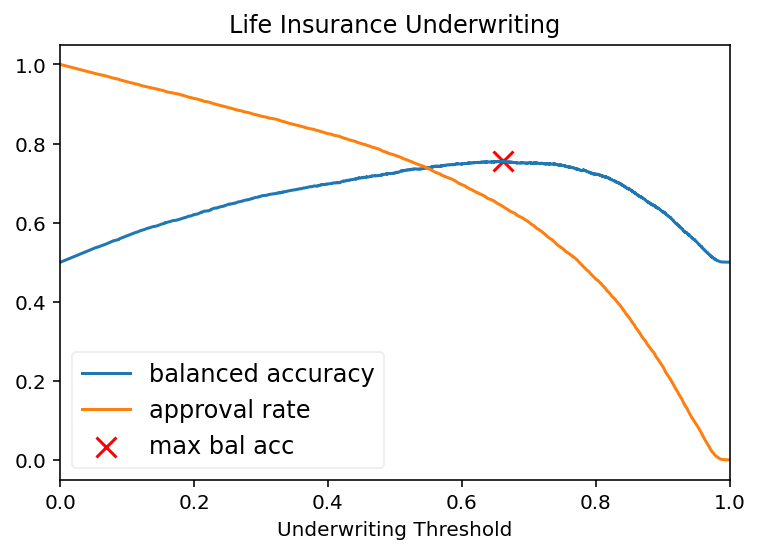

In [28]:
# plot balanced accuracy and approval rate vs threshold
ba = 0.5*(tpr + 1 - fpr)
base_ar = np.mean(y_test.astype(int))
ar = base_ar*tpr + (1-base_ar)*fpr
plt.plot(th, ba, label='balanced accuracy')
plt.plot(th, ar, label='approval rate')
plt.plot()
plt.scatter(best_th, best_ba, c='r', marker='x', s=100, label='max bal acc')
plt.xlabel('Underwriting Threshold')
plt.title('Life Insurance Underwriting')
plt.xlim((y_pred.min(), y_pred.max()))
plt.legend(framealpha=0.3, facecolor='white', fontsize=12, loc='lower left')
plt.show()

## Test Performance
Here we quantify the model's performance.

####  Code corresponding to section 2.7.3 Step 3: Build and Validate in Veritas Document 4 FEAT Principles Assessment Case Studies

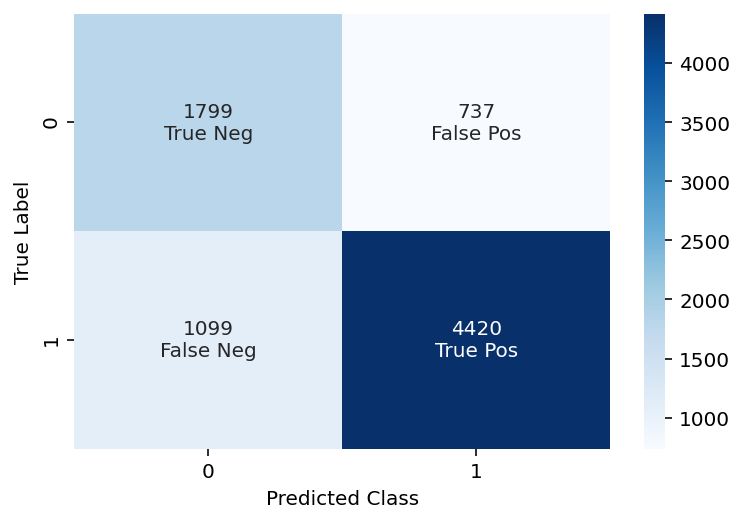

In [29]:
# compute confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted Class")
plt.ylabel("True Label")
plt.show()

NameError: name 'is_classifier' is not defined

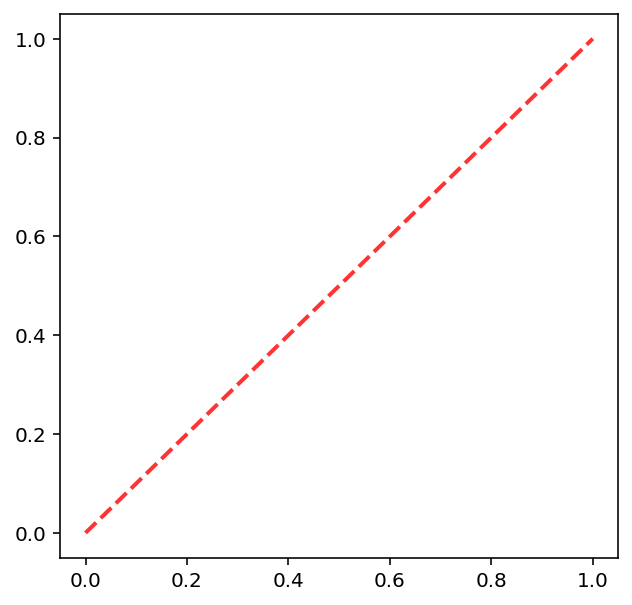

In [30]:
# plot ROC curve
def plot_roc(model, X, y):
    figure = plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Random Chance', alpha=.8)
    metrics.plot_roc_curve(model, X, y, name='model', alpha=0.3, lw=2, ax=plt.gca())
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=13)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.show()

plot_roc(model1, X_test_transformed, y_test)

In [ ]:
# save model
joblib.dump(model1, 'model/model_baseline_lr.pkl')

In [ ]:
# Bootstrap uncertainty analysis

# Metrics based on predictions
prediction_metrics = {'True Positive Rate (i.e. sensitivity, or recall)': metrics.recall_score,
                      'True Negative Rate (i.e. specificity)': lambda x, y: metrics.recall_score(x, y, pos_label=0),
                      'Balanced Accuracy': metrics.balanced_accuracy_score,
                      'Positive Predictive Value (precision)': metrics.precision_score}

# Metrics based on probabilities
probability_metrics = {'Area Under ROC': metrics.roc_auc_score}

for name, metric_func in prediction_metrics.items():
    print(name, ":", utils.format_uncertainty(*utils.bootstrap_conf_int(y_test.values, y_pred, metric_func, k=25)))

for name, metric_func in probability_metrics.items():
    print(name, ":", utils.format_uncertainty(*utils.bootstrap_conf_int(y_test.values, y_scores, metric_func, k=25)))

In [ ]:
# Calibration curve
def plot_calibration(bin_true_prob, bin_pred_prob):
    plt.figure(figsize=(7, 7))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="perfectly calibrated")
    ax1.plot(bin_pred_prob, bin_true_prob, "s-",
             label="model")

    ax2.hist([y_scores[y_test == 1], y_scores[y_test == 0]], label=["healthy", "risky"],
              histtype='bar', stacked=True)

    ax1.set_ylabel("Fraction of healthy applicants", fontsize=14)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right", fontsize=12)
    ax1.set_title('Model Calibration (reliability curve)', fontsize=16)

    ax2.set_xlabel("Model Output Probabilities (binned)", fontsize=14)
    ax2.set_ylabel("Count", fontsize=14)
    ax2.legend(loc="upper left", ncol=2, fontsize=12)

    plt.tight_layout()
    plt.show()

bin_true_prob, bin_pred_prob = calibration_curve(y_test, y_scores, n_bins=10)
plot_calibration(bin_true_prob, bin_pred_prob)

In [ ]:
# run Isotonic calibration
clf_isotonic = CalibratedClassifierCV(model1, cv=3, method='isotonic')
clf_isotonic = clf_isotonic.fit(X_train_transformed, y_train)
model1_iso = clf_isotonic.predict_proba(X_test_transformed)[:, 1]
model1_score = brier_score_loss(y_test, y_scores)
clf_isotonic_score = brier_score_loss(y_test, model1_iso)
print(model1_score, clf_isotonic_score)